TroySafe: Predicting crime and incidents for a safer neighborhood

The neighborhood around University of Southern California (USC) is paradoxically dangerous. Although it is located at the downtown area of Los Angeles, crimes aimed at USC students and staffs (Trojans) happen more than often, sometimes causing incidents as serious as homicides. When night falls, streets around USC are considered as no-go zones for causious pedestrian and cyclists.

To improve this situation, I propose to fuse and analyze historical crime and incident datasets from various sources, incuding daily incident logs from the Department of Public Safety (DPS) of USC, crime summaries from LAPD, etc. The analysis results would likely help identify important spatial and temporal crime patterns, providing a static knowledge for the reference of related parties. For instance, DPS can use the derived information to more effectively deploy security personnel (the Yellow Jackets) or prioritize the free student escorting system.

Moreover, data can be distilled into predictive machine learning models to capture the dynamics of crime and serve as a warning highlight to help people proactively avoid or prevent inpending incidents. Before, Trojans rely on a notification system, which can only report limited crimes incidents in hindsight. In contrast, the proposed system can push avoidance suggestions in advance to motivate Trojans away from street hazards. The prediction can also be visualized from a website or mobile APP to fascilite 24-7 access. 

In this very first phase, I scrapped from DPS website the crime logs (in PDF format) for the past three month and extracted structured information from the PDFs using PDFminer and regex. After transforming those into pandas.DataFrame, I performed some exploratory analysis from different angles, including time, location, and incident types. Some interesting findings are:
1. Although SERVICE-type minor incidents constitutes a major part of incidents, bursts of some more serious types do occure, e.g. THEFT-type incident surged on Nov 11, 2015. This is different from accidental colision of multiple incidents like Nov 28, 2015.
1. Investigating the week-day vs crime-type heatmap, it seems minor incidents (e.g. THEFT-PETTY) tend to precede more serious incidents (THEFT-GRAND). More spcifically THEFT-PETTY (x-axis 7) is high on week begining (y axis 5-7), whereas THEFT-GRAND (x-axis 3) happens more near weekend (y axis 3-4).

Plots for the above findings are drawn using mpl and Seaborn, exported as embeded js using mpld3, and hosted on Heroku. For next steps, I plan to accquire more crime logs from DPS and further incorporate the crime data from LAPD.

In [ ]:
# =====================Retrieve PDF=================================
from lxml import html
import requests
import urllib
page = requests.get('http://dps.usc.edu/alerts/log/')
tree = html.fromstring(page.content)
file_urls = tree.xpath('/html/body//a[contains(@href, \'http://dps.usc.edu/files/\')]/@href')
for file_url in file_urls:
    urllib.urlretrieve(file_url, file_url.split('/')[-1])

In [ ]:
# =====================Extract TXT from PDF===========================
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter, PDFPageAggregator
from pdfminer.layout import LAParams
from pdfminer.pdfdevice import PDFDevice
from cStringIO import StringIO
import os
def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = file(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()
    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)
    text = retstr.getvalue()
    fp.close()
    device.close()
    retstr.close()
    return text
for pdf_in in os.listdir("./data/pdf"):
    path_in = "./data/pdf/"+pdf_in
    path_out = path_in.replace("pdf", 'txt')
    with open(path_out, 'wb') as f:
        f.write(convert_pdf_to_txt(path_in))

In [ ]:
# ========================parse TXT -> DataFrame -> csv==========================
import re
import pandas as pd
import os
# Regular expressions for differetn fields
re_report_number = re.compile('Report #:\n\n(?P<report_number>\d+)\n\n') 
re_reported_time = re.compile('\n(\d{1,2}/\d{1,2}/\d{2}[\n-]*'
                              '[ ]*\d{1,2}:\d{2}[ ]+[ap]m)\n')
re_location = re.compile('Location:\n\n([a-zA-Z0-9 ,.\'&/\n]+)\n\n')
re_summary = re.compile('Summary:[\n -]+(?P<summary>[a-zA-Z0-9 ,.\-\n"\'/]*)\n\n')
re_disposition = re.compile('Disposition:[ \n]+(?P<disposition>[\w ]+)\n\n')
re_incident_type = re.compile('((Summary:[\n]{1,2})|'
                              '(\n\d{1,2}/\d{1,2}/\d{2}([\n ]+\d{1,2}:\d{2}[ ]+[ap]m){,1}[\n-]+(to)*[\n-]*))'  
                              '([A-Z& ]+[\-]*[A-Z& ]*)\n')
re_page_head = re.compile('University of Southern California\n\n'
                          'Department of Public Safety\n\n'
                          'Daily Incident Log\n\n'
                          'From \d{2}/\d{2}/\d{4} To \d{2}/\d{2}/\d{4}\n\n')
df_dict={}
# Iterate through file to get fields
for file in os.listdir('./data/txt/'):
    if '.txt' not in file:
        continue
    with open('./data/txt/'+file) as f:
        state = None
        string_page = "".join(f.readlines())
        string_page_noheader = re_page_head.sub('', string_page)
        string_incidents = string_page_noheader.split('Reported:')
        records = {}
        print file
        for i, s_in in enumerate(string_incidents):
            report_number = re_report_number.search(s_in)
            if report_number is not None:
                df_dict[int(report_number.groups()[0])] = {}
                report_time = re_reported_time.search(s_in)
                location = re_location.search(s_in)
                summary = re_summary.search(s_in)
                disp = re_disposition.search(s_in)
                ins = re_incident_type.search(s_in)
                ##
                df_dict[int(report_number.groups()[0])]['report_time'] = \
                    pd.Timestamp(report_time.groups()[0].replace('\n', ' ').replace('-', ' '))\
                    if report_time is not None else None
                df_dict[int(report_number.groups()[0])]['location'] = \
                    location.groups()[0].replace('\n', ' ').replace(';', ' ')\
                    if location is not None else None
                df_dict[int(report_number.groups()[0])]['summary'] = \
                    summary.groups()[0].replace('\n', ' ').replace(';', ' ')\
                    if summary is not None else None
                df_dict[int(report_number.groups()[0])]['disposition'] = \
                    disp.groups()[0].replace(';', ' ')\
                    if disp is not None else None
                df_dict[int(report_number.groups()[0])]['incident_type'] = \
                    ins.groups()[-1].replace(';', ' ')\
                    if ins is not None else None
                df_dict[int(report_number.groups()[0])]['raw_string'] = s_in.replace('\n', '[new_line]').replace(';', ' ')
df = pd.DataFrame.from_dict(df_dict, orient='index')
df.index.name = 'report_number'
df.to_csv('./data/usc_incident.csv', sep=';', index_label=True, columns=['report_time', 'location', 'incident_type', 'summary', 'raw_string'])

In [1]:
# ========================Analysis and Webpage Embedding==========================
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpld3
import seaborn as sns
%pylab inline
plt.style.use('ggplot')

# data ingestion
incidents = pd.read_csv('./data/usc_incident.csv', sep=';', index_col=0)
incidents['report_day'] = incidents['report_time'].apply(lambda x: pd.Timestamp(pd.Timestamp(x).date()))
incidents['report_DOW'] = pd.to_datetime(incidents['report_time'])
incidents['report_DOW'] = incidents['report_DOW'].dt.dayofweek
DOW = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']
num_byDay = incidents.groupby('report_day')['report_time'].agg(pd.Series.count)
num_byDay.name='TOTAL'
num_byDay_perType = incidents.groupby('report_day').apply(lambda x: x.groupby('incident_type')['raw_string'].agg(pd.Series.count)).reset_index(
).pivot(index='report_day', columns='incident_type', values='raw_string')  # idx=date, columns=Type, values=num
num_byDOW_perType = incidents.groupby('report_DOW').apply(lambda x: x.groupby('incident_type')['raw_string'].agg(pd.Series.count)).reset_index(
).pivot(index='report_DOW', columns='incident_type', values='raw_string')

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python2.7/dist-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/usr/local/lib/python2.7/dist-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/usr/local/lib/python2.7/dist-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  """
/usr/local/lib/python2.7/dist-packages/ipykernel/pylab/config.py:114: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g.,

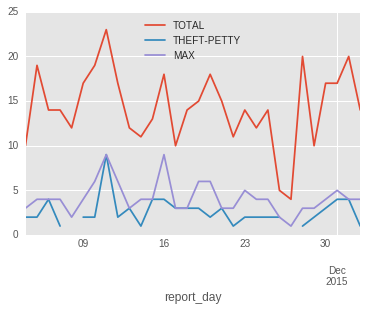

In [3]:
fig1 = plt.figure(0)
num_byDay.iloc[20:50].plot(legend=True)
num_byDay_perType[num_byDay_perType.columns[39]].iloc[20:50].plot(ax=fig1.axes[0], legend=True)
daily_max = num_byDay_perType.iloc[20:50].max(axis=1)
daily_max.name = 'MAX'
daily_max.plot(ax=fig1.axes[0], legend=True)
with open('fig1.html', 'wb') as f:
    f.write(mpld3.fig_to_html(fig1))

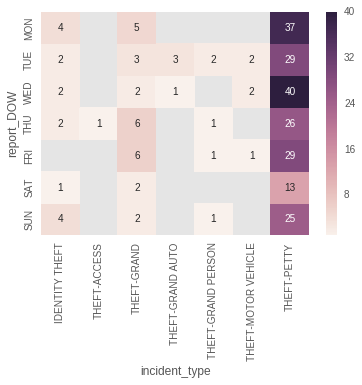

In [6]:
# fig2: THEFT-PETTY is high on week begining, whereas THEFT-GRAND happens more near weekend
fig2 = plt.figure(1)
a = num_byDOW_perType[[x for x in num_byDOW_perType if 'THEFT' in x]]
sns.heatmap(data=a, annot=True, xticklabels=a.columns.tolist(), yticklabels=DOW)
with open('fig2.html', 'wb') as f:
    f.write(mpld3.fig_to_html(fig2))

In [10]:
# https://sleepy-waters-53548.herokuapp.com/fig1
# https://sleepy-waters-53548.herokuapp.com/fig2